<a href="https://colab.research.google.com/github/MakhovaAnastasia/Paper_Fuzzy_LSTM/blob/main/Fuzzy_data_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Fuzzy LSTM для прогнозирования цен.***

Импортируем нужные библиотеки

In [ ]:
import pandas as pd
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date,timedelta
import sklearn.metrics
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,mean_absolute_percentage_error
from keras.utils import get_custom_objects
import time
from prettytable import PrettyTable

Собираем данные на разных тенорах

In [ ]:
def get_historical_close_data(name,step):
  if step=='1d':
    start = '2018-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1d')
    data.reset_index(inplace=True)
    data = data.loc[:,('Date','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1h':
    start = '2023-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1h')
    data.reset_index(inplace=True)
    data = data.loc[:,('Datetime','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1m':
    start = date.today()-timedelta(days=7)
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1m')
    data.reset_index(inplace=True)
    return data

Нормализация данных и денормализация

In [ ]:
def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)

    return data_norm

In [ ]:
def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)

    return unormalized

**Гауссианы.**Для каждого момента времени $t_i$ сопоставим известному значению ряда $x_i$ нечеткое множество, задающееся функцией принадлежности гауссовского типа $$ m(x) = \exp(- (\frac{x - c}{\sigma})^2)$$ с параметрами $c = x_i$ и $\sigma = \hat\sigma(t_i, l)$-- волатильность ряда за период длины $l$: $[t_{i-l}, t_i]$. То есть вершина гауссовского купола будет как раз в $x_i$ и его ширина'' будет соответствовать ширине'' обозреваемого ряда.


------



прогноз: $c$

In [ ]:
# 2. Фаззификация (гауссовая)
def compute_volatility(data, window):
    return pd.Series(data.flatten()).rolling(window).std().bfill().values

def fuzzify(data, window=10):
    sigma = compute_volatility(data, window)
    return np.exp(-((data.flatten() - data.flatten())**2) / (sigma**2 + 1e-8)).reshape(-1, 1)

In [ ]:
def create_dataset_multifeature_1(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), :]     # теперь берем все фичи
        dataX.append(a)
        dataY.append(dataset[i + lookback, 0])  # целевая переменная — всё так же первая (норм. цена)
    return np.array(dataX), np.array(dataY)

Разбиваем данные на тренировочную и тестовую выборку и преобразуем их в нужный для LSTM формат

In [ ]:
def split_train_test(data):

    # split into train and test sets
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test

def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
      a = dataset[i:(i+lookback), 0]
      dataX.append(a)
      dataY.append(dataset[i + lookback, 0])
    return np.array(dataX), np.array(dataY)

Так как в LSTM базовая функция активации -- tanh, по результатам прошлых лет выбираем следующие параметры:

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

In [ ]:
# === Фаззи-признак ===
fuzzy_feature = fuzzify(dataset_norm, window)

# Добавим фаззи-признак в нормализованный датасет
dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

train_X, train_y = create_dataset_multifeature_1(train_dataset_fuzzy, lookback)
test_X, test_y = create_dataset_multifeature_1(test_dataset_fuzzy, lookback)



train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)


Запускаем обучение LSTM с функцией потерь MSE и алгоритмом оптимизации ADAM

In [ ]:
model=Sequential()
model.add(Input(shape=(lookback,2)))
model.add(LSTM(unit))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
start_time = time.time()
result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
end_time = time.time()
train_timing=(end_time-start_time)
print(f"time = {train_timing}")

time = 245.79169940948486


Делаем прогноз на тренировочной и тестовой выборке

In [ ]:
train_predict=model.predict(train_X)
start_time = time.time()
test_predict=model.predict(test_X)
end_time = time.time()
test_timing=(end_time-start_time)
print(f"time = {test_timing}")

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
time = 0.2873110771179199


Возвращаем данные в исходные единицы измерения

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

График с оригинальными данными и прогнозами:

In [ ]:
trainPredictPlot = np.empty_like(dataset_norm)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
testPredictPlot = np.empty_like(dataset_norm)
testPredictPlot[:,] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

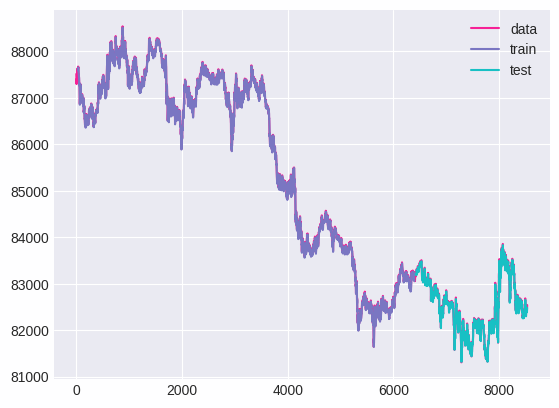

In [ ]:
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
plt.plot(trainPredictPlot,color = 'C0', label = 'train')
plt.plot(testPredictPlot,color = 'C3', label = 'test')
plt.legend()
plt.show()

Метрики:

In [ ]:
rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
mae_train=mean_absolute_error(original_ytrain,train_predict)
mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
mae_test=mean_absolute_error(original_ytest,test_predict)
mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)


+---------+------------------------+-----------------------+
| RESULTS |         TRAIN          |          TEST         |
+---------+------------------------+-----------------------+
|   rmse  |   45.127556972035784   |   54.357152575924296  |
|   mae   |   33.22336608685409    |    37.8815599726451   |
|   mape  | 0.00038766448339120604 | 0.0004588537718929537 |
+---------+------------------------+-----------------------+


График функций потерь:

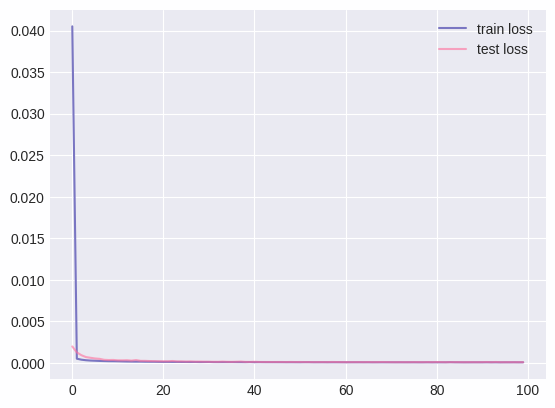

In [ ]:
plt.plot(result.history['loss'],label = 'train loss')
plt.plot(result.history['val_loss'],label = 'test loss')
plt.legend()
plt.show()

---------

прогноз: $(c, \sigma)$

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
# 3. Создание датасета с признаками
def create_dataset_multifeature(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, :])  # теперь y — вектор из 2 значений
    return np.array(dataX), np.array(dataY)

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

In [ ]:
# === Фаззи-признак ===
fuzzy_feature = fuzzify(dataset_norm, window)

# Добавим фаззи-признак в нормализованный датасет
dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

train_X, train_y = create_dataset_multifeature(train_dataset_fuzzy, lookback)
test_X, test_y = create_dataset_multifeature(test_dataset_fuzzy, lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)


In [ ]:
# === Модель ===
model = Sequential()
model.add(Input(shape=(lookback, 2)))  # Вот так правильно
model.add(LSTM(unit))
model.add(Dense(2))  # Выход: [предсказание цены, предсказание функции принадлежности]
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# === Обучение ===
start_time = time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=False)
train_time = time.time() - start_time
print(f"time = {train_time}")

time = 249.47161436080933


In [ ]:
# === Предсказания ===
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |   42.46293475116366   |   52.60346461697107   |
|   mae   |   30.12175082456416   |   35.594210870599426  |
|   mape  | 0.0003514568552370249 | 0.0004312438686134726 |
+---------+-----------------------+-----------------------+


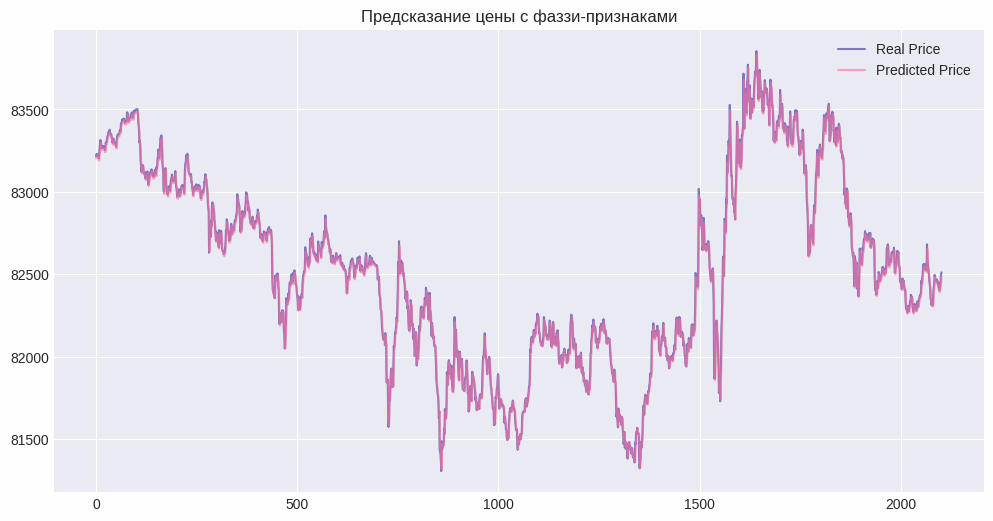

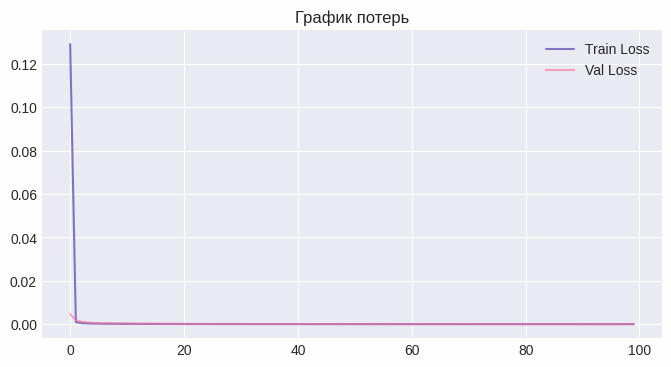

In [ ]:
# === Де-нормализация только для первого значения (цены) ===
train_price = scaler.inverse_transform(train_y[:, 0].reshape(-1, 1))
test_price = scaler.inverse_transform(test_y[:, 0].reshape(-1, 1))
train_pred_price = scaler.inverse_transform(train_predict[:, 0].reshape(-1, 1))
test_pred_price = scaler.inverse_transform(test_predict[:, 0].reshape(-1, 1))

# === Метрики ===
rmse_train= math.sqrt(mean_squared_error(train_price,train_pred_price))
mae_train=mean_absolute_error(train_price,train_pred_price)
mape_train=mean_absolute_percentage_error(train_price,train_pred_price)
rmse_test=math.sqrt(mean_squared_error(test_price, test_pred_price))
mae_test=mean_absolute_error(test_price, test_pred_price)
mape_test=mean_absolute_percentage_error(test_price, test_pred_price)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)

# === Визуализация ===
plt.figure(figsize=(12, 6))
plt.plot(test_price, label='Real Price')
plt.plot(test_pred_price, label='Predicted Price')
plt.title("Предсказание цены с фаззи-признаками")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("График потерь")
plt.legend()
plt.show()


Другой подход (Самый правильный):

+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |   31.647587348979812  |   38.148558070631495  |
|   mae   |   22.00328721336579   |   23.642940503092294  |
|   mape  | 0.0002541423875825095 | 0.0002816501518910723 |
+---------+-----------------------+-----------------------+


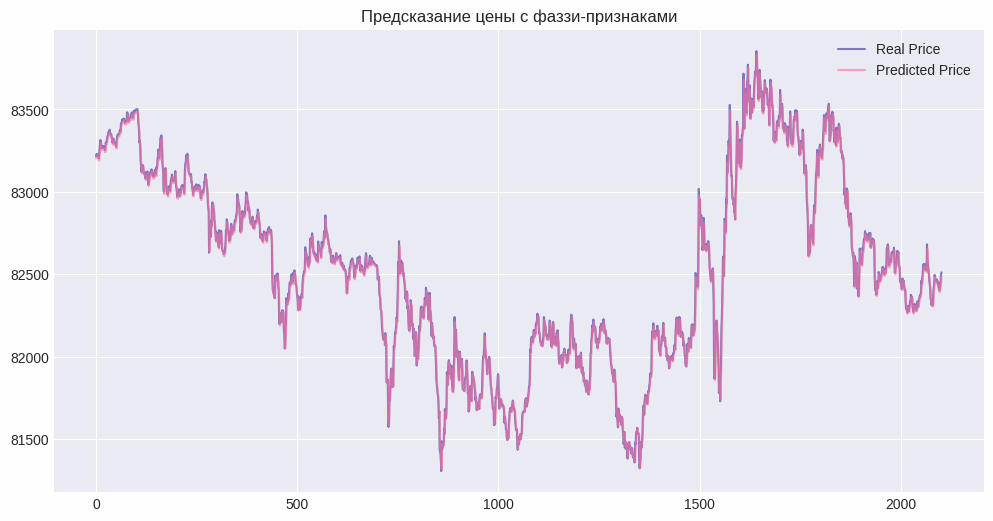

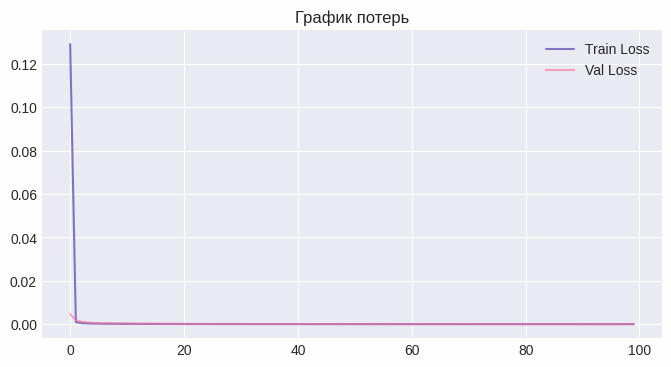

In [ ]:
#Де-нормализация предсказаний и реальных значений
train_pred_denorm = scaler.inverse_transform(train_predict.T.reshape(-1, 1))
test_pred_denorm = scaler.inverse_transform(test_predict.T.reshape(-1, 1))
y_train_denorm = scaler.inverse_transform(train_y.T.reshape(-1, 1))
y_test_denorm = scaler.inverse_transform(test_y.T.reshape(-1, 1))


# === Метрики ===
rmse_train= math.sqrt(mean_squared_error(y_train_denorm, train_pred_denorm))
mae_train=mean_absolute_error(y_train_denorm, train_pred_denorm)
mape_train=mean_absolute_percentage_error(y_train_denorm, train_pred_denorm)
rmse_test=math.sqrt(mean_squared_error(y_test_denorm, test_pred_denorm))
mae_test=mean_absolute_error(y_test_denorm, test_pred_denorm)
mape_test=mean_absolute_percentage_error(y_test_denorm, test_pred_denorm)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)

# === Визуализация ===
l = np.shape(y_test_denorm)[0]
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm[:int(l/2),0], label='Real Price')
plt.plot(test_pred_denorm[:int(l/2),0], label='Predicted Price')
plt.title("Предсказание цены с фаззи-признаками")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("График потерь")
plt.legend()
plt.show()




-------


----

**Probabilistic Fuzzy Sets**
- определим область рассуждений $U = [X_{min} - \sigma, X_{max} + \sigma], X_{min}$ и $X_{max}$ -- минимальные и максимальные значения ряда за обозреваемый период, $\sigma$ -- дисперсия.
- Разобьем $U$ на $m$ равных интервалов $e_i$ и зададим на них треугольными функциями принадлежности нечеткие множества $F_i$


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, time
from datetime import date, timedelta
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prettytable import PrettyTable

In [ ]:

# === 1️⃣ Параметры
step = '1m'
companies = 'BTC-USD'
lookback = 30
unit = 16
m_fuzzy = 14  # количество нечетких множеств

In [ ]:
# === 2️⃣ Загрузка данных
def get_historical_close_data(name, step):
    if step == '1d':
        start, end, interval = '2018-01-01', '2024-02-15', '1d'
    elif step == '1h':
        start, end, interval = '2023-01-01', '2024-02-15', '1h'
    else:
        start, end, interval = date.today() - timedelta(days=7), date.today(), '1m'
    data = yf.Ticker(name).history(start=start, end=end, interval=interval)
    data.reset_index(inplace=True)
    return data[['Close']]

In [ ]:
# === 3️⃣ Фаззификация
def probabilistic_fuzzy_transform(data, m):
    X_min, X_max = np.min(data), np.max(data)
    sigma = np.std(data)
    U_min, U_max = X_min - sigma, X_max + sigma
    centers = np.linspace(U_min, U_max, m)

    def triangle_membership(x):
        membership = np.zeros(m)
        for i, c in enumerate(centers):
            if i == 0:
                left, right = centers[i], centers[i+1]
            elif i == m-1:
                left, right = centers[i-1], centers[i]
            else:
                left, right = centers[i-1], centers[i+1]
            if left < x < c:
                membership[i] = (x - left) / (c - left)
            elif c < x < right:
                membership[i] = (right - x) / (right - c)
            elif x == c:
                membership[i] = 1
            else:
                membership[i] = 0
        return membership

    fuzzy_data = np.array([triangle_membership(x[0]) for x in data])
    return fuzzy_data, centers

In [ ]:
# === 4️⃣ Дефаззификация
def defuzzify(output_fuzzy, centers):
    return np.dot(output_fuzzy, centers) / np.sum(output_fuzzy, axis=1)

In [ ]:
def create_dataset_multifeature(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, :])
    return np.array(dataX), np.array(dataY)

In [ ]:
# === 5️⃣ Создание датасета
def create_dataset(X, y, lookback):
    dataX, dataY = [], []
    for i in range(len(X) - lookback - 1):
        dataX.append(X[i:i+lookback])
        dataY.append(y[i + lookback,:])
    return np.array(dataX), np.array(dataY)

In [ ]:
# === 🔁 Загрузка и преобразование
raw_data = get_historical_close_data(companies, step)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(raw_data.values)
fuzzy_data, centers = probabilistic_fuzzy_transform(scaled_close, m_fuzzy)

#X, y = create_dataset(fuzzy_data, scaled_close, lookback)

X, y = create_dataset(fuzzy_data, fuzzy_data, lookback)
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# === 6️⃣ Обучение модели
model = Sequential()
model.add(Input(shape=(lookback, m_fuzzy)))  # Вот так правильно
model.add(LSTM(unit))
model.add(Dense(m_fuzzy))  # Выход — вероятности принадлежности
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
start_time = time.time()
result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)
train_time = time.time() - start_time

In [ ]:
# === 7️⃣ Прогноз
train_pred_fuzzy = model.predict(X_train)
test_pred_fuzzy = model.predict(X_test)

train_pred = defuzzify(train_pred_fuzzy, centers)
test_pred = defuzzify(test_pred_fuzzy, centers)
y_train_defuzzy = defuzzify(y_train, centers)
y_test_defuzzy = defuzzify(y_test, centers)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# === 8️⃣ Де-нормализация
train_pred_denorm = scaler.inverse_transform(train_pred.reshape(-1,1))
test_pred_denorm = scaler.inverse_transform(test_pred.reshape(-1,1))
y_train_denorm = scaler.inverse_transform(y_train_defuzzy.reshape(-1,1))
y_test_denorm = scaler.inverse_transform(y_test_defuzzy.reshape(-1,1))

+--------+------------------------+-----------------------+
| METRIC |         TRAIN          |          TEST         |
+--------+------------------------+-----------------------+
|  RMSE  |   47.97719195859565    |   57.64621501887154   |
|  MAE   |   35.276680300800905   |   41.010659762795214  |
|  MAPE  | 0.00041166642357427476 | 0.0004970602465432128 |
+--------+------------------------+-----------------------+


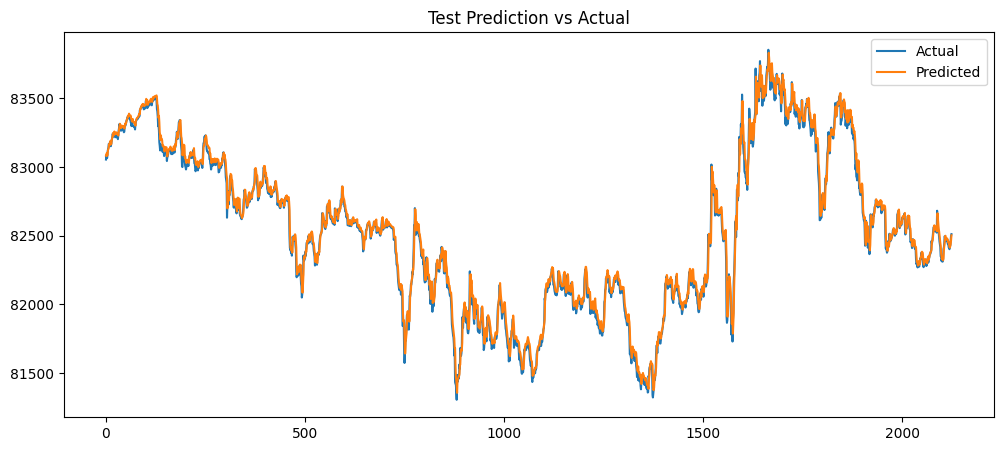

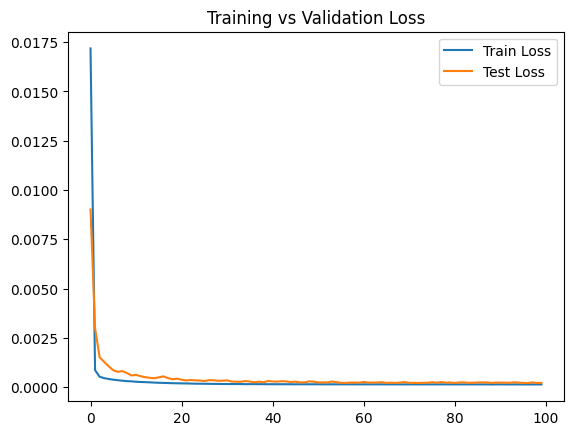

In [ ]:
# === 9️⃣ Метрики
def calc_metrics(y_true, y_pred):
    return (
        math.sqrt(mean_squared_error(y_true, y_pred)),
        mean_absolute_error(y_true, y_pred),
        mean_absolute_percentage_error(y_true, y_pred)
    )

rmse_train, mae_train, mape_train = calc_metrics(y_train_denorm, train_pred_denorm)
rmse_test, mae_test, mape_test = calc_metrics(y_test_denorm, test_pred_denorm)

table = PrettyTable()
table.field_names = ["METRIC", "TRAIN", "TEST"]
table.add_row(["RMSE", f"{rmse_train:}", f"{rmse_test:}"])
table.add_row(["MAE", f"{mae_train:}", f"{mae_test:}"])
table.add_row(["MAPE", f"{mape_train:}", f"{mape_test:}"])
print(table)

# === 🔟 График предсказаний
plt.figure(figsize=(12,5))
plt.plot(y_test_denorm, label="Actual")
plt.plot(test_pred_denorm, label="Predicted")
plt.title("Test Prediction vs Actual")
plt.legend()
plt.show()

# === 📉 График потерь
plt.plot(result.history['loss'], label='Train Loss')
plt.plot(result.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


---------
----------